In [1]:
import matplotlib
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, h5py as h5, sys
from functools import partial
from pylab import cm
from Convenience import *

fontsize=18


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}


matplotlib.rcParams.update({'font.size': fontsize, 'xtick.labelsize':fontsize, 'ytick.labelsize':fontsize})



Here we produce the likelihood function for the model analyzed in Piro & Gaensler 2018.
This is done via Monte Carlo simulations using their theoretical predictions with samples of theit parameters that follow resonable prior distributions.

theoretical predictions for DM and RM in uniform ISM and wind-driven environment

In [4]:
## known constants

mu_e = 1.16 ## CHECK!!! electron mean molecular weight
mu = 1.16 ## CHECK !!! mean molecular weight
mu = 1.67 ## sun, 0.76 H, 0.26 He 0.01 Metal
mu = 0.62 ## Piro18 !!! why ???
mu_i = 1.3 ## Piro18

m_p = 1.67e-24 ## g
M_sun = 1.99e33 ## g
R_sun = 2.25e-8 ## pc
rho_nuc = 2.8e14 ## g cm^-3

pc2cm = 2.09e18 ## pc in cm

#x_ = v_rot/v_w * 10 ## p. 8, last pargraph  probably about 1
x__ = 0.1
x_ = x__ * 10
epsilon_B = 0.1  ## potion of shock energy that goes into magnetic energy
epsilon = epsilon_B*10

a_c = 1.8e-7 # for SM with n in cm^-3, L0 in 0.001 pc


## units:
## E in 1e51 erg
## M in solar mass
## K in 1e13 g/cm
## t in years
## R in 100 R_sun
## B in G
## n in cm^-3, number density of uniform ambient ISM
## DM in pc/cm^3
## RM in rad/m^2

## equations from Piro & Gaensler 2018

def t_ST( E, M, n ): ## yr
    return 210 * E**-0.5 * M**0.83 * n**-0.33 ## Eq. 1

def R_ST( M, n ):  ## pc
    return 2.2 * ( M / n )**(1./3)   ## Eq. 2

def v_ST( E, M ):  ## cm /s
    return 1e9 * E**0.5 * M**-0.5 ## Eq 3 in cm/s

def R_CH( M, K ): ## pc
    return 16.8 * M / K ## Eq. 33

def t_CH( E, M, K ):  ## yr
    return 1.9e3 * E**-0.5 * M**1.5 * K**-1  ## Eq. 34

def v_CH( E, M ): ## cm/s
    return 6.9 * 1e9 * E**0.5 * M**-0.5

def t_snow( E, n ):   ## yr
    ## results only applicable below this limit
    return 4.9e4 * E**0.22 * n**-0.55  ## Eq. 6

def t_max( E, n ):
    return t_snow( E, n )

def t_diss( L, B, dB, rho ): ## yr
    ## L in cm
    ## B, dB in G
    ## rho in g cm^-3
    return 600. * (L*1e-5)**1.6 * (dB*1e-16)**0.4 * (B*1e-16)**-1.6 * ( rho / rho_nuc )**1.2  ## (33) in Beloborodorov & Li 2016

def t_max( L, B, rho ):
    ## set dB ~ B
    return t_diss( L, B, B, rho )


def R(M): ## R_sun,  stellar radius from Radius-Mass relation
    return 1.33 * M**0.555 # Demircan & Kahraman 1990

'''  ## this version uses their results in tables 1 & 2. However, these are only reliable t << t_ST or t >> t_ST (or t_CH), better use the clean calculation below
def DM_uniform( E, M, n, t ):    
    DM_e = 52.6 * mu/mu_e * E**-0.25 * M**0.75 * n**0.5 * t**-0.5 ## Eq. 16, SNR
    DM_l = 1.8 * E**0.2 * n**0.8 * (t/1000)**0.4 ## Eq. 21, ISM 
#    return DM_e, DM_l
    return DM_e + DM_l
#    return np.where( t < t_ST( E, M, n ), DM_e, DM_l )

def RM_uniform( E, M, n, t ):
    RM_e = 1.8e5 * mu**1.5/mu_e * epsilon**0.5 * E**0.25 * M**0.25 * n * t**-0.5 ## Eq. 28, SNR
    RM_l = 810. * epsilon**0.5 * E**0.4 * n**1.1 * (t/1000)**-0.2 ## Eq. 30, ISM
    return RM_e + RM_l
#    return np.where( t < t_ST( E, M, n ), RM_e, RM_l )  

def DM_wind( E, M, K, t ):
    DM_e = 1.3e4 * mu_e**-1 * E**-0.75 * M**1.25 * K**0.5 * t**-1.5  ##  Eq. 42
    DM_l = 1.9e-2 * mu_e**-1 * E**-0.33 * K**1.33 * t**-0.67  ##  Eq. 52
    return DM_e + DM_l
#    return np.where( t < t_CH( E, M, K), DM_e, DM_l)

def RM_wind( E, M, K, t, B):
    RM_e = 2e3 * x_ * R(M) * B * mu_e**-1 * E**-1 * M * t**-2 ## Eq. 59, w
    RM_l = 1.7e-3 * x_ * R(M) * B * mu_e**-1 * E**-0.67 * K**1.67 * (t/1000)**-1.33 ## Eq. 61, w
    return RM_e + RM_l
#    return np.where( t < t_CH( E, M, K), RM_e, RM_l)
'''

## clean version

## R's and v's from table 1 and 2

def v_R( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## v is in terms of v_st or v_ch
#    t_st = t_ST( E, M, n )
    if typ == 'uniform':
        v_r_e = 1.41 * t**1.5 * ( 1 + 1.13*t**1.5 )**(-5./3)
        v_r_l = 0.37 + 0.03*t
    elif typ == 'wind':
        v_r_e = 1.06 * t**0.5 * ( 1 + 0.7*t**0.5 )**-3
        v_r_l = 0.19 + 0.02*t
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, v_r_e, v_r_l)
    

def v_B( t, typ='uniform'  ):
    ## t must be in terms of t_st or t_ch !!!
    ## v is in terms of v_st or v_ch
    if typ == 'uniform':
        v_b_e = 1.37 * ( 1 + 0.6*t**1.5 )**(-5./3)
        v_b_l = 0.63*( 1.56*t - 0.56 )**-0.6
    elif typ == 'wind':
        v_b_e = 1.79 * ( 1 + 0.33*t**0.5 )**-3
        v_b_l = 0.74 * ( 1.11*t - 0.11 )**(-1./3)
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, v_b_e, v_b_l)

def R_B( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## R is in terms of R_st or R_ch
    if typ == 'uniform':
        R_b_e = 1.37* t * ( 1 + 0.6*t**1.5 )**(-2./3)
        R_b_l = ( 1.56*t - 0.56 )**0.4
    elif typ == 'wind':
        R_b_e = 1.79 * t * ( 1 + 0.33*t**0.5 )**-2
        R_b_l = ( 1.11*t - 0.11 )**(2./3)
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, R_b_e, R_b_l)

def R_C( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## R is in terms of R_st or R_ch
    if typ == 'uniform':
        R_c_e = 1.24* t * ( 1 + 0.6*t**1.5 )**(-2./3)
        R_c_l = 0.91*( 1.56*t - 0.56 )**0.4
    elif typ == 'wind':
        R_c_e = 1.5 * t * ( 1 + 0.33*t**0.5 )**-2
        R_c_l = 0.84 * ( 1.11*t - 0.11 )**(2./3)
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, R_c_e, R_c_l)

def R_R( t, typ='uniform' ):
    ## t must be in terms of t_st or t_ch !!!
    ## R is in terms of R_st or R_ch
    if typ == 'uniform':
        R_r_e = 1.24* t * ( 1 + 1.13*t**1.5 )**(-2./3)
        R_r_l = t * ( 0.78 - 0.03*t - 0.37*np.log(t) )
    elif typ == 'wind':
        R_r_e = 1.5*t * ( 1 + 0.7*t**0.5 )**-2
        R_r_l = t * ( 0.54 - 0.02*t -0.19*np.log(t))
    else:
        sys.exit( "typ %s not defined" % typ )
    return np.where( t < 1, R_r_e, R_r_l)

''' ## old attempts of no use
def B_SNR( E, M, n ):
    ## !!! 4.1e-3
    return 4.1e3 * mu**0.5 * epsilon**0.5 * E**0.5 * M**-0.5 * n**0.5  # Eq. 27 in muG

def B_ISM( E, n, t ):
    ## !!! 5.6e-4
    return 5.6e2 * epsilon**0.5 * E**0.2 * n**0.3 * (t/1000)**-0.6  # Eq. 29 in muG
'''


def KineticEnergy( rho, v ):
    return 0.5 * rho * v**2

def Kinetic2MagneticEnergy( E_kin ):
    return np.sqrt( 0.8*np.pi * E_kin ) 

def B_SNR_uniform( M, t, R_st, v_st ): ## G
    ## t must be in terms of t_st
#    t_ = t/t_st( E, M, n )
    rho = 3./4/np.pi * M*M_sun * ( R_C( t ) * R_st * pc2cm )**-3
    return Kinetic2MagneticEnergy( KineticEnergy( rho, v_R( t )*v_st ) )
#    return np.sqrt( 0.8*np.pi * KineticEnergy( rho, v_R( t )*v_st ) ) 

def B_ISM( n, t, v_st ): ## G
    ## t must be in terms of t_st
    rho = 4 * n * m_p
    return Kinetic2MagneticEnergy( KineticEnergy( rho, v_B( t )*v_st ) )
#    return np.sqrt( 0.8*np.pi * KineticEnergy( rho, v_B( t )*v_st ) ) 


def RotationMeasure( DM, B ):
    ## DM in pc cm^-3, B in G, RM in rad m^-2
    return 0.81e6 * DM * B ## Eq. 26


def DMRM_uniform( E, M, n, t, L0=None ):
    t_ = t / t_ST( E, M, n )
    n_r = mu/mu_e * 4 * n * ( v_B(t_)/v_R(t_) )**2 ## Eqs. 11 & 12
    R_b = R_B( t_ )
    R_c = R_C( t_ )
    R_r = R_R( t_ )
    R_st = R_ST( M, n )
    v_st = v_ST( E, M )
    dR_cr = np.where( R_r > 0, R_c - R_r, R_c ) * R_st  ## R_c where R_r < 0
    dR_bc = ( R_b - R_c ) * R_st
    DM_SNR = n_r * dR_cr ## Eq. 10
    DM_ISM = 4 * n * dR_bc ## Eq. 13
#    RM_SNR = RotationMeasure( DM_SNR, B_SNR( E, M, n ) )
#    RM_ISM = RotationMeasure( DM_ISM, B_ISM( E, n, t ) )
    RM_SNR = RotationMeasure( DM_SNR, B_SNR_uniform( M, t_, R_st, v_st ) )
    RM_ISM = RotationMeasure( DM_ISM, B_ISM( n, t_, v_st ) )
    if L0 is None:
        return DM_SNR + DM_ISM, RM_SNR + RM_ISM
    else:
        SM_SNR = a_c * L0**(-2./3) * n_r**2 * dR_cr
        SM_ISM = a_c * L0**(-2./3) * 16 * n**2 * dR_bc
        return DM_SNR + DM_ISM, RM_SNR + RM_ISM, (SM_SNR + SM_ISM) * 1e-3 # SM in kpc



def B_phi(  B_star, R_star, R_b, R_c, R_ch ): ## same units as B_star
    return 2 * B_star * x__ * R_star/R_ch * R_b / ( R_b**2 - np.where( R_c > 0, R_c, 0 )**2 )  
#    return 2 * B_star * x_ * R_star*R_sun * R_b / ( R_b**2 - R_c**2 ) / R_ch 

def B_SNR_wind( t, rho_w, v_ch ): ## G
    ## t must be in terms of t_ch
    return Kinetic2MagneticEnergy( KineticEnergy( rho_w, v_R( t, typ='wind' )*v_ch ) )
#    return np.sqrt( 0.8*np.pi * KineticEnergy( rho_w, v_R( t, typ='wind' )*v_ch ) )



def DMRM_wind( E, M, K, t, B_star, SNR_RM=False, L0=None ):
    t_ = t / t_CH( E, M, K)
    R_ch = R_CH( M, K )
    v_ch = v_CH( E, M )
    R_b = R_B( t_, typ='wind' )
    R_c = R_C( t_, typ='wind' )
    R_r = R_R( t_, typ='wind' )
    dR_cr = np.where( R_r > 0, R_c - R_r, R_c ) * R_ch  ## R_c where R_r < 0
    dR_bc = np.where( R_c > 0, R_b - R_c, R_b ) * R_ch
    R_star = R(M)*R_sun
    R_star = 100*R_sun ## to exactly mimic PG18
    
    rho_w = K * 1e13 * ( R_b*R_ch*pc2cm )**-2 ## Eq. 31
    n = 4 * rho_w / mu_e / m_p 
#    n_r = n * ( v_B(t_, typ='wind')/v_R(t_, typ='wind') )**2 ## Eq. 37
    n_r = n / mu_e * ( v_B(t_, typ='wind')/v_R(t_, typ='wind') )**2 ## Eq. 37
    DM_SNR = n_r * dR_cr ## Eq. 10
    DM_sh = n * dR_bc  ## Eq. 38
    DM_unsh = n / 4 * R_b * R_ch  ## Eq. 39
    
    RM_SNR = RotationMeasure( DM_SNR, B_SNR_wind( t_, rho_w, v_ch ) )
    RM_sh = RotationMeasure( DM_sh, B_phi( B_star, R_star, R_b, R_c, R_ch )  )
    if L0 is None:
        return DM_SNR + DM_sh + DM_unsh, RM_sh + RM_SNR*SNR_RM
    else:
        SM_SNR = a_c * L0**(-2./3) * n_r**2 * dR_cr
        SM_sh = a_c * L0**(-2./3) * n**2 * dR_bc
        SM_unsh = a_c * L0**(-2./3) * n**2 / 16 * R_b * R_ch
        return DM_SNR + DM_sh + DM_unsh, RM_sh + RM_SNR*SNR_RM, ( SM_SNR + SM_sh + SM_unsh ) * 1e-3 # SM in kpc


test the results and compare to figures in PG18

/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarnin

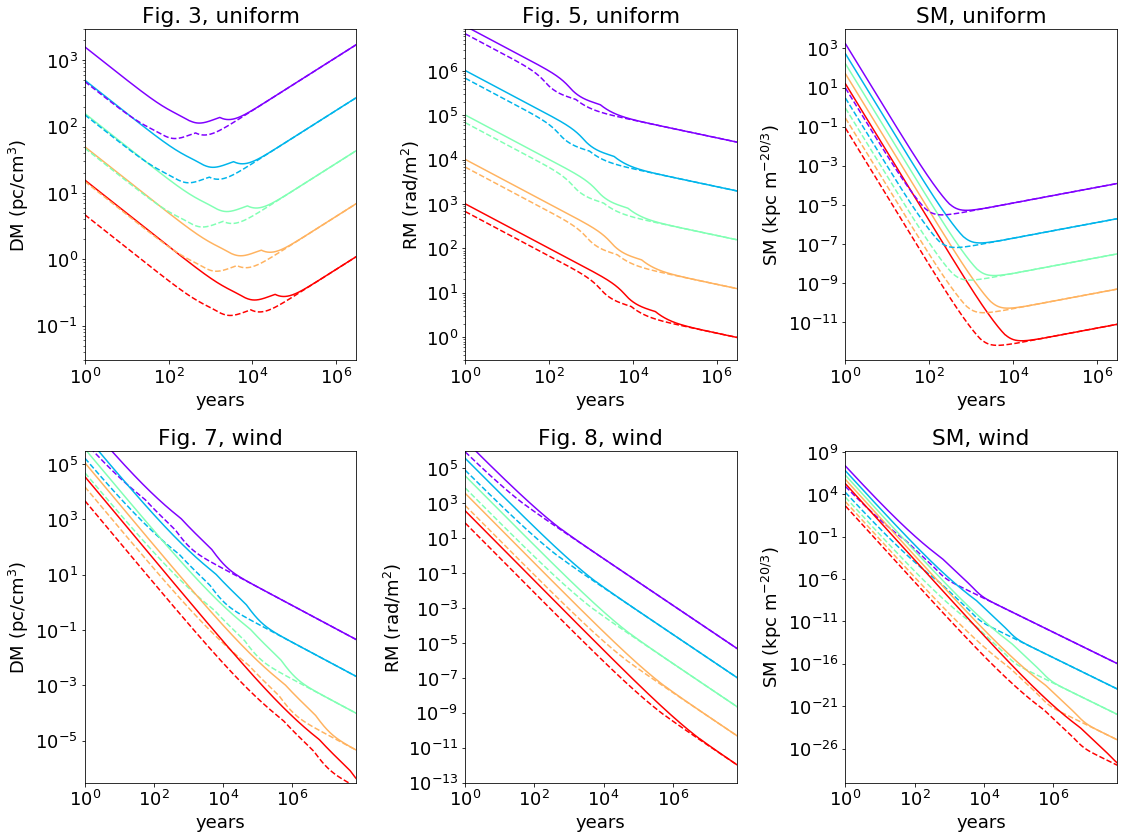

In [7]:
ts = 10.**np.linspace(0, 8, 1000)
E = 1.
#R = 100.
B = 1.

fig, axs = plt.subplots( 2, 3, figsize=(16,12))

ns = [1e-2, 1e-1, 1., 1e1, 1e2]
colors = cm.rainbow( np.linspace( 0, 1, len( ns ) ) )

for n0, color in zip( ns, colors[::-1] ):
    for M, line in zip( [10, 2], ['-','--'] ):
        DM, RM, SM = DMRM_uniform( E, M, n0, ts, L0=1 )
        axs[0][0].loglog( ts, DM, linestyle=line, color=color )
        axs[0][1].loglog( ts, RM, linestyle=line, color=color )
        axs[0][2].loglog( ts, SM, linestyle=line, color=color )
axs[0][0].set_title( 'Fig. 3, uniform')
axs[0][0].set_xlabel('years')
axs[0][0].set_ylabel(r"DM (pc/cm$^3$)")
axs[0][0].set_xlim(1, 3e6)
axs[0][0].set_ylim(3e-2, 3e3)

axs[0][1].set_title( 'Fig. 5, uniform')
axs[0][1].set_xlabel('years')
axs[0][1].set_ylabel(r"RM (rad/m$^2$)")
axs[0][1].set_xlim(1, 3e6)
axs[0][1].set_ylim(3e-1, 9e6)

axs[0][2].set_title( 'SM, uniform')
axs[0][2].set_xlabel('years')
axs[0][2].set_ylabel(r"SM (kpc m$^{-20/3}$)")
axs[0][2].set_xlim(1, 3e6)
#axs[0][2].set_ylim(3e-1, 9e6)

n0=1

Ks = [1e-2, 1e-1, 1e0, 1e1, 1e2]
colors = cm.rainbow( np.linspace( 0, 1, len( Ks ) ) )

for K, color in zip( Ks[::-1], colors ):
    for M, line in zip( [10, 2], ['-','--'] ):
        DM, RM, SM = DMRM_wind( E, M, K, ts, B, L0=1 )
        axs[1][0].loglog( ts, DM, linestyle=line, color=color )
        axs[1][1].loglog( ts, RM, linestyle=line, color=color )
        axs[1][2].loglog( ts, SM, linestyle=line, color=color )
axs[1][0].set_title( 'Fig. 7, wind')
axs[1][0].set_xlabel('years')
axs[1][0].set_ylabel(r"DM (pc/cm$^3$)")
axs[1][0].set_xlim(1, 7e7)
axs[1][0].set_ylim(3e-7, 3e5)

axs[1][1].set_title( 'Fig. 8, wind')
axs[1][1].set_xlabel('years')
axs[1][1].set_ylabel(r"RM (rad/m$^2$)")
axs[1][1].set_xlim(1, 7e7)
axs[1][1].set_ylim(1e-13, 1e6)

axs[1][2].set_title( 'SM, wind')
axs[1][2].set_xlabel('years')
axs[1][2].set_ylabel(r"SM (kpc m$^{-20/3}$)")
axs[1][2].set_xlim(1, 7e7)
#axs[1][2].set_ylim(1e-13, 1e6)


plt.tight_layout()
plt.show()



RM results of wind case do only account for the region shocked by the wind, wile it does not include contribution from the SNR. The former naturally holds large scale magnetic field, which makes it a robust estimate, while the latter is probably more tangled. Hence the SNR+wind case is a too optimistic estimate.

/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in power
/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in power
/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in power


(1e-13, 1000000.0)

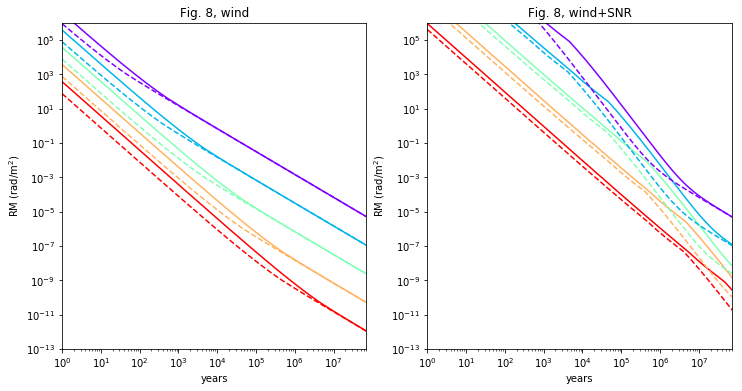

In [339]:
n0=1

fig, axs = plt.subplots( 1, 2, figsize=(12,6))


Ks = [1e-2, 1e-1, 1e0, 1e1, 1e2]
colors = cm.rainbow( np.linspace( 0, 1, len( Ks ) ) )

for K, color in zip( Ks[::-1], colors )[::-1]:
    for M, line in zip( [10, 2], ['-','--'] ):
        t_f = np.inf #t_max( E, n0 ) * 1000
        hit = np.where( ts < t_f )[0]
        for i in [0,1]:
            DM, RM = DMRM_wind( E, M, K, ts, B, SNR_RM=i )
#        axs[0].loglog( ts[hit], DM[hit], linestyle=line, color=color )
            axs[i].loglog( ts[hit], RM[hit], linestyle=line, color=color )
axs[0].set_title( 'Fig. 8, wind')
axs[0].set_xlabel('years')
axs[0].set_ylabel(r"RM (rad/m$^2$)")
axs[0].set_xlim(1, 7e7)
axs[0].set_ylim(1e-13, 1e6)

axs[1].set_title( 'Fig. 8, wind+SNR')
axs[1].set_xlabel('years')
axs[1].set_ylabel(r"RM (rad/m$^2$)")
axs[1].set_xlim(1, 7e7)
axs[1].set_ylim(1e-13, 1e6)


We now derive the prior distribution function for the time since SN t.
We use a flat distribution until the strong magnetic field of the magnetar dissipates.
The dissipation time t_diss is given in Beloborodov & Li 2016.
Since the parameters are distinct of and unrelated to parameters used in Piro & Gaensler 2018, we sample t_diss to derive the decay of P at high times.

In [8]:
def Sample_B_NS( N, mu=2.5e14, sigma=0.5 ):  ## standard values fitted to Ferrario & Wickramasinghe 2008, Fig 1
    y = np.random.lognormal( mean=np.log(mu), sigma=sigma, size=N )
    return y

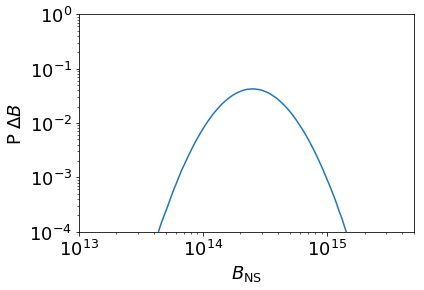

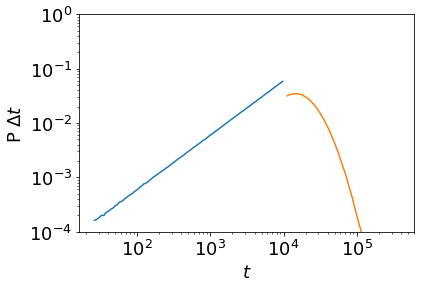

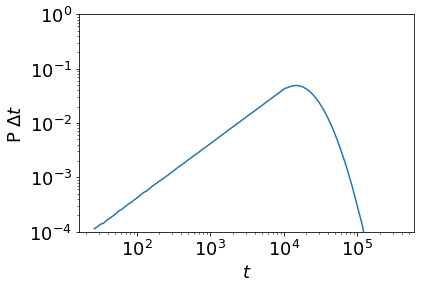

In [9]:
N = 10**7  ## sample size

## parameters assumed to be constant
L = 1e5 # cm
rho = 1e14 # g cm^-3

## sample magnetic field of magnetars
B = Sample_B_NS( N )
P, x = histogram( B, bins=100, density=True, log=True )
PlotLikelihood( x, P, density=False,log=True )
plt.xlim(1e13,5e15)
plt.ylim(1e-4,1)
plt.xlabel( r"$B_{\rm NS}$" )
plt.ylabel( r"P $\Delta B$" )
plt.show()


fig, ax = plt.subplots()

## sample flat time at low t
# t, flat t_lo to t_hi, t_lo = 25 yr, Margalit et al. 2018, t_hi chosen for smooth transition
t_lo = 25
t_hi = 1e4
Sample_t = partial( np.random.uniform, high=t_hi, low=t_lo )

ts = Sample_t( size=N )

P, x = histogram( ts, bins=100, density=True, log=True )
PlotLikelihood( x, P, density=False,log=True, ax=ax )


## compute dissipation time of sample
tdiss = t_max( L, B, rho )
## use only high t for smooth results
in_, = np.where( tdiss > t_hi*1.1 )

P_diss, x_diss = histogram( tdiss[in_], bins=100, density=True, log=True )
PlotLikelihood( x_diss, P_diss, density=False, log=True, ax=ax )

ax.set_ylim(1e-4,1)
ax.set_xlabel( r"$t$" )
ax.set_ylabel( r"P $\Delta t$" )
plt.show()

## combine to single likelihood function
P_t, x_t = AddLikelihoods( [P, P_diss], [x,x_diss], weights=[1,1.2] )  # weights for smooth transition

PlotLikelihood( x_t, P_t, density=False,log=True )
#plt.xlim(1e13,5e15)
plt.ylim(1e-4,1)
plt.xlabel( r"$t$" )
plt.ylabel( r"P $\Delta t$" )
plt.show()

Pd_t = P_t*np.diff(x_t)


[ 0.93844968  2.54324877  2.6399141 ]


/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply


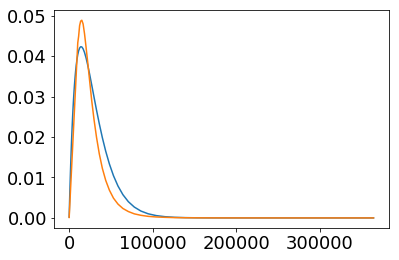

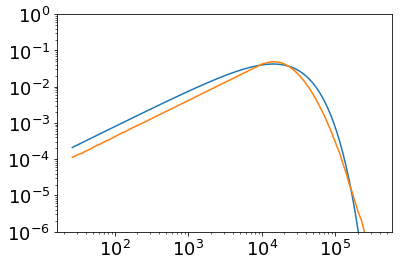

'  \n## why is this fit so bad ???\nplt.plot( x_, Pd_t )\n#plt.plot( x_, gamma_( x_/gamma_xmax, th=fit[0] ) )\n#plt.plot( x_, gamma_( x_/gamma_xmax, th=2. ) )\nplt.plot( x_, ff( x_, *fit ) )\nplt.show()\nplt.loglog( x_, Pd_t )\n#plt.loglog( x_, gamma_( x_/gamma_xmax, th=fit[0] ) )\nplt.loglog( x_, ff( x_, *fit ) )\nplt.ylim(1e-6,1)\nplt.show()\n'

In [10]:
from scipy.optimize import curve_fit
from scipy.special import gamma as gamma_fct

def f( x, a=1., b=1., c=1., d=1. ):
    return (a + x**b ) * np.exp( - (x+c)/d )
#    return (a*x+b)*np.exp( - (x+c)/d )

def beta( x, a=1, b=1, N=1, x_max=1):
    x_ = x/x_max
    return x_**(1-a) * (1-x_)**(1-b) / N

def gamma( x, th=1., N=1., k=1., x_max=1. ):
    x_ = x/x_max
    return x_**(k-1) * np.exp( -x_/th ) * th**-k /gamma_fct(k) / N



def f( x, a=1., b=1., c=1., x0=0, x_max=1. ):
    x_ = x/x_max
    return x_**a * np.exp( -(x_ - x0)*b ) * c

def ff( x, a=1., x0=0, N=1. ):
    return N * x_ * np.exp( -(x_ - x0)*a )


#np.random.gamma( shape, scale, size=N )

dx_ = np.diff(x_t)
x_ = x_t[:-1] + dx_/2
f_ = partial(f, x_max=x_[-1])
beta_ = partial(beta, x_max=x_[-1])
#gamma_ = partial(gamma, x_max=x_[-1])
gamma_xmax = 1e4
gamma_ = partial(gamma, k=2, x_max=gamma_xmax, N=1)



#fit, sig = curve_fit( gamma_, x_, Pd_t, p0=(3. ) )
fit, sig = curve_fit( ff, x_, Pd_t, p0=(1.,1.,1. ) )

print fit
#plt.plot( x_, beta(x_, 8.6, 1/123e3, 1.27e3))
#plt.plot( x_, gamma(x_, 9., 0.5, 0.5e4, 1e1))
###plt.loglog( x_, f_(x_, 1., 26., 1.6, 1./44))
#plt.loglog( x_, f_(x_, 1., 26., 1.6, 1./44))

plt.plot( x_, ff(x_, 7e-5, 1e4, 4e-6))
plt.plot( x_, Pd_t )
#plt.ylim(1e-6,1)
plt.show()
plt.loglog( x_, ff(x_, 7e-5, 1e4, 4e-6))
plt.plot( x_, Pd_t )
plt.ylim(1e-6,1)
plt.show()

'''  
## why is this fit so bad ???
plt.plot( x_, Pd_t )
#plt.plot( x_, gamma_( x_/gamma_xmax, th=fit[0] ) )
#plt.plot( x_, gamma_( x_/gamma_xmax, th=2. ) )
plt.plot( x_, ff( x_, *fit ) )
plt.show()
plt.loglog( x_, Pd_t )
#plt.loglog( x_, gamma_( x_/gamma_xmax, th=fit[0] ) )
plt.loglog( x_, ff( x_, *fit ) )
plt.ylim(1e-6,1)
plt.show()
'''


Here we sample the parameter spaces with prior distributions explained in more detail in Hackstein et al. 2019

In [11]:
def uniform_log( lo, hi, N ):
    ## returns N samples of a log-flat distribution from lo to hi
    lo = np.log10(lo)
    hi = np.log10(hi)
    return 10.**np.random.uniform( lo, hi, N )
    

# Energy of SN explosion E, lognormal, mu=2e51 erg,  sigma=5e50 erg
### !!! now set constant to 1.2e51 erg, see Woosley & Weaver 1995
mu = np.log(2)
sigma = 0.2
mu = np.log(1.8)
sigma = 0.15
#Sample_E = partial( np.random.lognormal, mean=mu, sigma=sigma )
Sample_E = lambda N: np.random.lognormal( size=N, mean=mu, sigma=sigma )
## use constant energy 1.2e51 erg instead
def Sample_E( N ):
    return 1.2

# mass of SN ejecta M, salpeter function - mass of neutron star
M_min, M_max = 20, 45 ## mass range of seed stars of magnetars, see Ferrario & Wickramasignhe 2008
M_NS = 1.5 ## mass of neutron star
def salpeter( m ):
    return m**(-2.35)
## invert cumulative distribution function u = F(M) => F^-1(u) = M, use uniform distribution (0,1) for u
def M_invert( u ):
#    return 30.2 / ( 4.467 - 3.78*u )**0.74
    return ( 0.017523 - 0.01166*u )**(-1./1.35)

def Sample_M( N ):
    u = np.random.uniform(low=0,high=1,size=N)
    return M_invert( u ) - M_NS


# wind mass loading parameter K, log-flat K_min=1e11 g/cm, K_max=1e15 g/cm
K_min, K_max = 1e-2, 1e2  ## in 1e13 g/cm
Sample_K = partial( uniform_log, K_min, K_max)

''' # completely flat prior is not reasonable
# t, flat t_min to t_max, 
t_lo = 25
t_hi = 1e7
t_hi = 3e6
Sample_t = partial( np.random.uniform, high=t_hi, low=t_lo )
'''

from scipy.special import lambertw
# time since SN explosion t, flat from t_min to t_diss, then from sampled t_diss, see above
## t_min = 25 yr, Margalit et al. 2018, t_diss from Beloborodov & Li 2016
t_lo = 25
t_hi = 1e6
## invert cumulative distribution function u = F(t) => F^-1(u) = t, use uniform distribution (0,1) for u
def t_invert( u, a=7e-5, t1=t_lo, t_max=t_hi ):
    at1, at_max = a*t1, a*t_max
    c = ( 1 - u ) * np.exp( -at1 ) * ( at1 + 1 ) + u * np.exp( -at_max ) * ( at_max + 1 )
    return - np.real( lambertw( -c*np.exp(-1), k=-1 ) + 1 ) / a

def Sample_t( N ):
    u = np.random.uniform( low=0, high=1, size=N )
    return t_invert( u )
    




# ISM density n_ISM, ranges from Ferriere 2001 with known filling factors
n_ISM = np.array([
    [1e-4, 1e-2], # Hot Ionized Medium
    [0.2, 0.5],   # Warm Ionized and Neutral Medium
    [20, 50],     # Cold Neutral Medium
    [1e2, 1e4]    # HII regions
])
p_ISM = [
    0.53,         # Hot Ionized Medium
    0.43,         # Warm Ionized and Neutral Medium
    0.03,         # Cold Neutral Medium
    0.01          # HII regions    
]
th = [0]
th.extend( np.cumsum( p_ISM ) )


def Sample_n_Ferriere01( N ):
    ## choose which range to pick from for each pick
    r = np.random.uniform( low=0, high=1, size=N )
    res = []
    ## for each range
    for i, (t0, t1) in enumerate( zip( th[:-1], th[1:] ) ):
    ##   count picks 
        count = np.sum( (t0 < r)*(r < t1) )    
    ##   do the desired number of picks
        res.extend( uniform_log( n_ISM[i][0], n_ISM[i][1], count ) )
    ## return all
    return np.array(res)
    
# magntic field of seed star B, log-flat 800 - 1500 G, compare Ferrario & Wickramasinghe 2008
B_min, B_max = 8e2, 1.5e3
Sample_B = partial( uniform_log, B_min, B_max)



## number density of ISM n_ISM in IC10,  use Allivez 2005, Fig. 7
n_lo = 5e-3
n_hi = 3e0
Sample_n_IC10 = lambda N: uniform_log( n_lo, n_hi, N )

## magnetic field of host dwarf galaxy iC10 B_Host,  use Chyzy 2016, Tab. 3
B_ic10_lo = 5e-1
B_ic10_hi = 5e0
Sample_B_IC10 = lambda N: uniform_log( B_ic10_lo, B_ic10_hi, N )







We check that the samples recreate the desired distribution

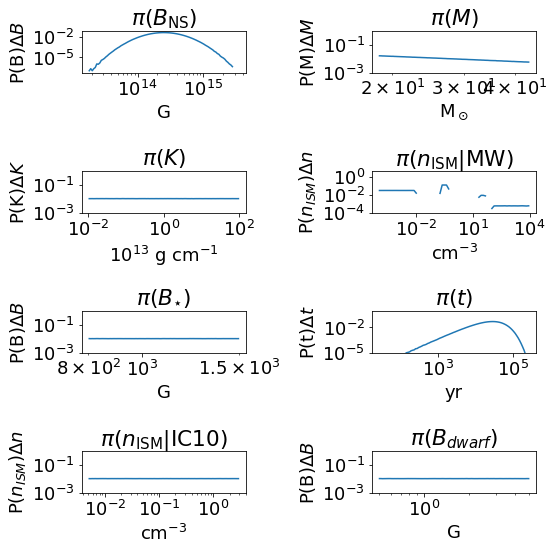

In [22]:
ylim = (1e-5,1)
#plt.figure( figsize=(12,10) )

N = 10**7

matplotlib.rc('font', **font)

fig, axs = plt.subplots( 4, 2, figsize=(8,8) )
axs = axs.flatten()

#plt.subplot(3, 2, 1)
B = Sample_B_NS( N )
P, x = histogram(B, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(B_{\rm NS})$", ax=axs[0] )
axs[0].set_title( r"$\pi(B_{\rm NS})$" )
axs[0].set_ylabel("P(B)$\Delta B$")
axs[0].set_xlabel(r"G")
'''
E = Sample_E( N)
P, x = histogram(E, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label="$\pi(E)$", ax=axs[0] )
axs[0].set_ylim(1e-5,1)
#axs[0].set_xlim(1,4)
axs[0].set_ylabel("P(E)$\Delta E$")
axs[0].set_xlabel(r"10$^{51}$ erg")
'''

#plt.subplot(3, 2, 2)
M = Sample_M( N)
P, x = histogram(M, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label="$\pi(M)$", ax=axs[1] )
axs[1].set_title("$\pi(M)$")
axs[1].set_ylim(1e-3,1)
axs[1].set_ylabel("P(M)$\Delta M$")
axs[1].set_xlabel(r"M$_\odot$")

#plt.subplot(3, 2, 3)
K = Sample_K( N )
P, x = histogram(K, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(K)$", ax=axs[2] )
axs[2].set_title( r"$\pi(K)$" )
axs[2].set_ylim(1e-3,1)
axs[2].set_ylabel(r"P(K)$\Delta K$")
axs[2].set_xlabel(r"$10^{13}$ g cm$^{-1}$")
axs[2].set_xticks( [1e-2, 1, 1e2])

#plt.subplot(3, 2, 4)
n = Sample_n_Ferriere01( N )
P, x = histogram(n, log=True, density=True, bins=70)
PlotLikelihood( x, P, density=False, label=r"$\pi(n_{\rm ISM}|\rm MW)$", ax=axs[3] )
#n = Sample_n_IC10( N )
#P, x = histogram(n, log=True, density=True, bins=100)
#PlotLikelihood( x, P, density=False, label=r"$\pi(n_{\rm ISM}|\rm IC10)$", ax=axs[3] )
axs[3].set_title( r"$\pi(n_{\rm ISM}|\rm MW)$" )
axs[3].set_ylim(1e-4,5)
axs[3].set_ylabel("P($n_{ISM}$)$\Delta n$")
axs[3].set_xlabel(r"cm$^{-3}$")

#plt.subplot(3, 2, 5)
B = Sample_B( N )
P, x = histogram(B, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(B_{\star})$", ax=axs[4] )
axs[4].set_title( r"$\pi(B_{\star})$" )
axs[4].set_ylim(1e-3,1)
axs[4].set_ylabel("P(B)$\Delta B$")
axs[4].set_xlabel(r"G")
axs[4].set_xticks( [ 800, 1500], minor=True )

#plt.subplot(3, 2, 6)
t = Sample_t( N )
P, x = histogram(t, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(t)$", ax=axs[5] )
axs[5].set_title( r"$\pi(t)$" )
axs[5].set_ylim(1e-5,1)
axs[5].set_ylabel("P(t)$\Delta t$")
axs[5].set_xlabel(r"yr")


n = Sample_n_IC10( N )
P, x = histogram(n, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(n_{\rm ISM}|\rmIC10)$", ax=axs[6] )
axs[6].set_title( r"$\pi(n_{\rm ISM}|\rmIC10)$" )
axs[6].set_ylim(1e-3,1)
axs[6].set_ylabel("P($n_{ISM}$)$\Delta n$")
axs[6].set_xlabel(r"cm$^{-3}$")

B = Sample_B_IC10( N )
P, x = histogram(B, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"$\pi(B_{\rm \it dwarf})$", ax=axs[7] )
axs[7].set_title( r"$\pi(B_{\rm \it dwarf})$" )
axs[7].set_ylim(1e-3,1)
axs[7].set_ylabel("P(B)$\Delta B$")
axs[7].set_xlabel(r"G")
#axs[7].set_xticklabels( [0.5,5], minor=True )



'''
for ax in axs:
    ax.legend()
'''
plt.tight_layout()
plt.show()



Finally, we compute the likelihood function in a Monte Carlo simulation. 
We use the samples created above to mimic candidates, compute the corresponding DM, RM, SM and their distribution functions

In [29]:
'''
## pick random numbers from the priors
##   check whether they fit the requirements ( t < t_max(E,n) )

ff = 6
ff = 1

def Likelihood_DM_uniform( N, bins=100, Sample_n=Sample_n_Ferriere01 ):
    M = Sample_M( ff*N )
    E = Sample_E( size=ff*N )
    n = Sample_n( ff*N )
    t = Sample_t( ff*N )
    
#    ok = np.where( t < t_max( E, n ) )[0][:N]
#    print float(len(ok))/N
#    DM = DM_uniform( E[ok], M[ok], n[ok], t[ok] )
    DM = DM_uniform( E, M, n, t )
    print DM.max()
    
    P, x = histogram( DM, log=True, density=True, bins=bins )
    return P, x
    
def Likelihood_RM_uniform( N, bins=100, Sample_n=Sample_n_Ferriere01 ):
    M = Sample_M( ff*N )
    E = Sample_E( size=ff*N )
    n = Sample_n( ff*N )
    t = Sample_t( ff*N )
    
#    ok = np.where( t < t_max( E, n ) )[0][:N]
#    RM = RM_uniform( E[ok], M[ok], n[ok], t[ok] )
    RM = RM_uniform( E, M, n, t )
    print RM.max()
    
    P, x = histogram( RM, log=True, density=True, bins=bins )
    return P, x

fff = 50
fff = 1

def Likelihood_DM_wind( N, bins=100 ):
    M = Sample_M( fff*N )
    E = Sample_E( size=fff*N )
    K = Sample_K( fff*N )
    t = Sample_t( fff*N )
    
#    ok = np.where( t < t_max( E, n ) )[0][:N]
    DM = DM_wind( E, M, K, t )
#    DM = DM_wind( E[ok], M[ok], K[ok], t[ok] )
    print DM.max()
    
    P, x = histogram( DM, log=True, density=True, bins=bins )
    return P, x


def Likelihood_RM_wind( N, bins=100 ):
    M = Sample_M( fff*N )
    E = Sample_E( size=fff*N )
    K = Sample_K( fff*N )
    t = Sample_t( fff*N )
    B = Sample_B( fff*N )
    
#    ok = np.where( t < t_max( E, n ) )[0][:N]
#    RM = RM_wind( E[ok], M[ok], K[ok], t[ok], B[ok] )
    print M.size, K.size, t.size, B.size
    RM = RM_wind( E, M, K, t, B )
    print RM.max()
    
    P, x = histogram( RM, log=True, density=True, bins=bins )
    return P, x
'''

## clean version

def Likelihood_DMRM_uniform( N, bins=100, Sample_n=Sample_n_Ferriere01, L0=None ):
    M = Sample_M( N )
    E = Sample_E( N )
    n = Sample_n( N )
    t = Sample_t( N )
    
    Ms = DMRM_uniform( E, M, n, t, L0=L0 )
    results = []
    for i in range(len(Ms)):
        results.extend( histogram( Ms[i], log=True, density=True, bins=bins ) )
    return results
#    return np.array([ histogram( Ms[i], log=True, density=True, bins=bins ) for i in range(len(Ms)) ]).flatten()

    ''' 
    old

    DM, RM = DMRM_uniform( E, M, n, t )
    
    P_DM, x_DM = histogram( DM, log=True, density=True, bins=bins )
    P_RM, x_RM = histogram( RM, log=True, density=True, bins=bins )
    return P_DM, x_DM, P_RM, x_RM
    '''

def Likelihood_DMRM_wind( N, bins=100, SNR_RM=False, L0=None ):
    M = Sample_M( N )
    E = Sample_E( N )
    K = Sample_K( N )
    t = Sample_t( N )
    B = Sample_B( N )
    
    Ms = DMRM_wind( E, M, K, t, B, SNR_RM=SNR_RM, L0=L0 )
    results = []
    for i in range(len(Ms)):
        results.extend( histogram( Ms[i], log=True, density=True, bins=bins ) )
    return results
#    return np.array([ histogram( Ms[i], log=True, density=True, bins=bins ) for i in range(len(Ms)) ]).flatten()

    ''' 
    old
    DM, RM = DMRM_wind( E, M, K, t, B, SNR_RM=SNR_RM )

    P_DM, x_DM = histogram( DM, log=True, density=True, bins=bins )
    P_RM, x_RM = histogram( RM, log=True, density=True, bins=bins )
    return P_DM, x_DM, P_RM, x_RM
    '''


/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in power
/media/hqi/bc66589e-7bcd-4650-a007-acbd38d85bc9/virtualenv/crpropa/lib/python2.7/site-packages/ipykernel_launcher.py:131: RuntimeWarnin

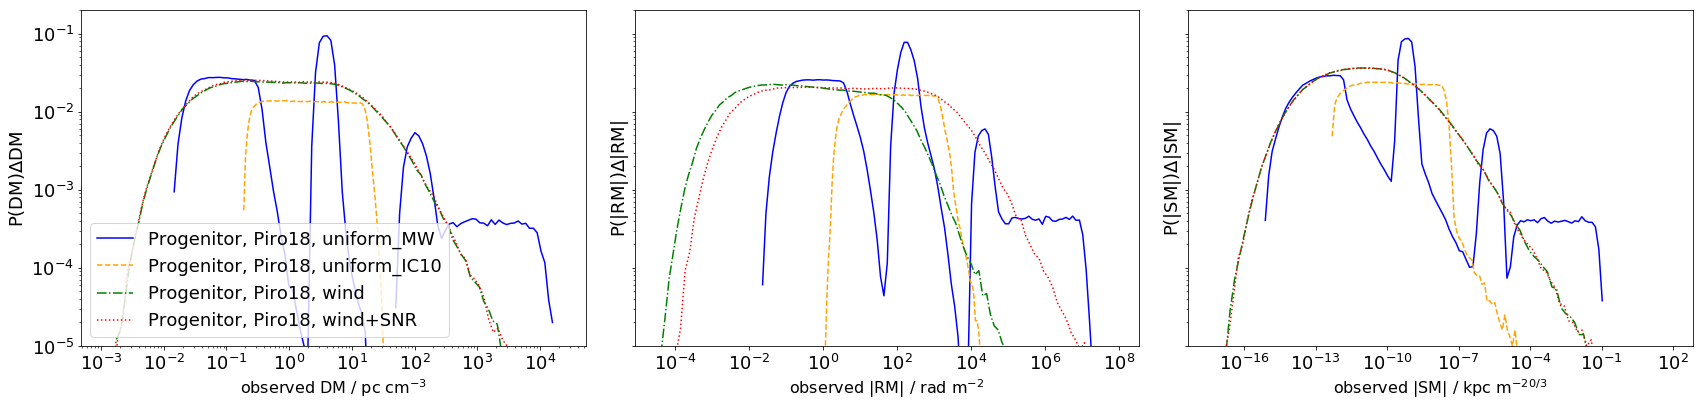

In [45]:
N = 10**6
bins = 100

fig , axs = plt.subplots( 1, 3, figsize=(24,6), sharex='col', sharey='row' )
axs = axs.flatten()

fig.subplots_adjust( hspace=0, wspace=0 )

measures = ['DM', 'RM', 'SM']

Ls = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_Ferriere01, L0=1 )
for im, m in enumerate(measures):
    PlotLikelihood( Ls[2*im+1], Ls[2*im], density=False, label=r"Progenitor, Piro18, uniform_MW", ax=axs[im], measure=m, color='blue'  )

Ls = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_IC10, L0=1 )
for im, m in enumerate(measures):
    PlotLikelihood( Ls[2*im+1], Ls[2*im], density=False, label=r"Progenitor, Piro18, uniform_IC10", ax=axs[im], measure=m, linestyle='--', color='orange'  )

Ls = Likelihood_DMRM_wind( N, bins=bins, L0=1 )
for im, m in enumerate(measures):
    PlotLikelihood( Ls[2*im+1], Ls[2*im], density=False, label=r"Progenitor, Piro18, wind", ax=axs[im], measure=m, linestyle='-.', color='green'  )

Ls = Likelihood_DMRM_wind( N, bins=bins, SNR_RM=True, L0=1 )
for im, m in enumerate(measures):
    PlotLikelihood( Ls[2*im+1], Ls[2*im], density=False, label=r"Progenitor, Piro18, wind+SNR", ax=axs[im], measure=m, linestyle=':', color='red'  )

'''
P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_Ferriere01 )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Progenitor, Piro18, uniform_MW", ax=axs[0], measure='DM', color='blue'  )
PlotLikelihood( x_RM, P_RM, density=False, label=r"Progenitor, Piro18, uniform_MW", ax=axs[1], measure='RM', color='blue' )

P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_uniform( N, bins=bins, Sample_n=Sample_n_IC10 )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Progenitor, Piro18, uniform_IC10", ax=axs[0], measure='DM', linestyle='--', color='orange'  )
PlotLikelihood( x_RM, P_RM, density=False, label=r"Progenitor, Piro18, uniform_IC10" , ax=axs[1], measure='RM', linestyle='--', color='orange' )


P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_wind( N, bins=bins )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Progenitor, Piro18, wind", ax=axs[0], measure='DM', linestyle='-.', color='green'  )
PlotLikelihood( x_RM, P_RM, density=False, label="Progenitor, Piro18, wind", ax=axs[1], measure='RM', linestyle='-.', color='green' )

P_DM, x_DM, P_RM, x_RM = Likelihood_DMRM_wind( N, bins=bins, SNR_RM=True )
PlotLikelihood( x_DM, P_DM, density=False, label=r"Progenitor, Piro18, wind+SNR", ax=axs[0], measure='DM', linestyle=':', color='red'  )
PlotLikelihood( x_RM, P_RM, density=False, label="Progenitor, Piro18, wind+SNR", ax=axs[1], measure='RM', linestyle=':', color='red' )
'''

axs[0].set_ylim(1e-5,2e-1)
#axs[2].set_ylim(1e-5,2e-1)

axs[0].legend()
#axs[2].legend()
#for ax in axs:
#    ax.legend(loc='lower center')

plt.tight_layout()
plt.show()

Finally, compute all progenitor models and write their likelihood functions to file.
Their position in the LikelihoodFile can be found by calling

<center> KeyProgenitor( "Piro18/" + model, <'DM' or 'RM'>, <'P' or 'x'> ) </center>



In [9]:
## this is the final list of progenitor models in this work
progenitor_models = ['uniform/JF12','uniform/Heesen11','wind','wind+SNR']

def MakeProgenitorLikelihoods( N=10**7, bins=100 ):
    ## !!! ATTENTION !!! the order in which the models are computed should be the same as in progenitor_models
    data = []
    for Host, sample_n in zip( ['JF12', 'Heesen11'], [Sample_n_Ferriere01, Sample_n_IC10] ):
        data.extend( Likelihood_DMRM_uniform( N, bins=bins, Sample_n=sample_n ) )
    data.extend( Likelihood_DMRM_wind( N, bins=bins ) )
    data.extend( Likelihood_DMRM_wind( N, bins=bins, SNR_RM=True ) )
    keys = [ KeyProgenitor( '/'.join(["Piro18",m]), measure, axis ) for m in progenitor_models for measure in ['DM', 'RM'] for axis in ['P','x']    ]
    Write2h5( likelihood_file_progenitor, data, keys )

    

In [10]:
MakeProgenitorLikelihoods()

/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in power
/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in power
/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: invalid value encountered in power
/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in power
/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in power
/data/virtualenv/crpropa_latest/lib/python2.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in power


In [57]:
likelihood_file_progenitor

'data/FRB/DMRMlikelihood_progenitor.h5'

In [56]:
with h5.File(likelihood_file_progenitor) as f:
    print f['Piro18/uniform'].keys()

[u'Heesen11', u'JF12']


In [60]:
with h5.File(likelihood_file_galaxy) as f:
    print f[u'Host/Heesen11/dirty'].keys()

[u'DM', u'RM']


In [7]:
with h5.File(likelihood_file_IGM) as f:
    print f['primordial/near/64'].keys()

[u'DM', u'RM', u'|RM|']


In [16]:
with h5.File(likelihood_file_Full) as f:
    print f.keys()

[]
